# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

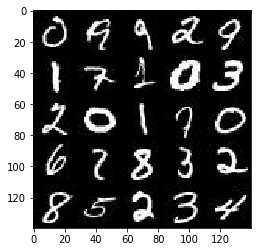

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

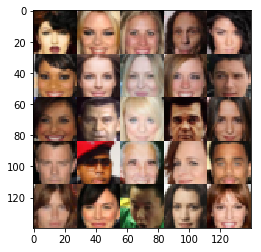

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real    = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z       = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, kernel_size=4, keep_prob=0.5):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        # 14 x 14 x 64
        x1 = tf.layers.dropout(images, rate = keep_prob)
        x1 = tf.layers.conv2d(x1, 64, kernel_size, strides = 2, padding = 'same')
        x1 = tf.maximum(alpha * x1, x1)

        # 7 x 7 x 128
        x2 = tf.layers.conv2d(x1, 128, kernel_size, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 4 x 4 x 256
        x3 = tf.layers.conv2d(x2, 256, kernel_size, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate = keep_prob)

        # logits(1)
        flat = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, kernel_size=4):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True if not is_train else False
    with tf.variable_scope('generator', reuse = reuse):
        # 4 x 4 x 512
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 7 x 7 x 256
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size, strides = 1, padding = 'valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14 x 14 x 128
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 28 x 28 x out_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides = 2, padding = 'same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                            logits = d_logits_real,
                            labels = tf.ones_like(d_logits_real) * (1 - smooth)
                        )
                    )
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                            logits = d_logits_fake,
                            labels = tf.zeros_like(d_logits_fake)
                        )
                    )
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits = d_logits_fake,
                        labels = tf.ones_like(d_logits_fake)
                    )
                )
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    one_epoch_steps = len(list(get_batches(batch_size)))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Input of Generator
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run optimizer
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                steps_in_epoch = one_epoch_steps if steps % one_epoch_steps == 0 else steps % one_epoch_steps
                if steps_in_epoch == one_epoch_steps or steps_in_epoch % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}\t".format(epoch_i + 1, epoch_count),
                          "Batch {}/{}\t".format(steps_in_epoch, one_epoch_steps),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps_in_epoch == one_epoch_steps or steps_in_epoch % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2	 Batch 10/468	 Discriminator Loss: 2.1523	 Generator Loss: 16.3920
Epoch 1/2	 Batch 20/468	 Discriminator Loss: 1.0815	 Generator Loss: 4.2346
Epoch 1/2	 Batch 30/468	 Discriminator Loss: 1.1674	 Generator Loss: 0.7986
Epoch 1/2	 Batch 40/468	 Discriminator Loss: 1.3038	 Generator Loss: 0.6212
Epoch 1/2	 Batch 50/468	 Discriminator Loss: 1.7831	 Generator Loss: 4.2850
Epoch 1/2	 Batch 60/468	 Discriminator Loss: 1.1118	 Generator Loss: 1.9119
Epoch 1/2	 Batch 70/468	 Discriminator Loss: 1.4766	 Generator Loss: 2.3812
Epoch 1/2	 Batch 80/468	 Discriminator Loss: 1.6235	 Generator Loss: 1.9483
Epoch 1/2	 Batch 90/468	 Discriminator Loss: 1.3766	 Generator Loss: 2.3977
Epoch 1/2	 Batch 100/468	 Discriminator Loss: 1.2993	 Generator Loss: 2.7265
Epoch 1/2	 Batch 110/468	 Discriminator Loss: 1.2657	 Generator Loss: 2.9355
Epoch 1/2	 Batch 120/468	 Discriminator Loss: 1.0143	 Generator Loss: 2.9468
Epoch 1/2	 Batch 130/468	 Discriminator Loss: 1.3337	 Generator Loss: 4.8237
Epoch 1

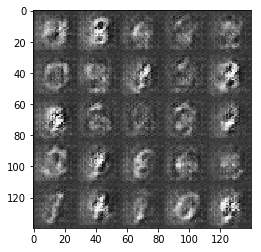

Epoch 1/2	 Batch 210/468	 Discriminator Loss: 1.9239	 Generator Loss: 2.6233
Epoch 1/2	 Batch 220/468	 Discriminator Loss: 0.6434	 Generator Loss: 4.5441
Epoch 1/2	 Batch 230/468	 Discriminator Loss: 0.7644	 Generator Loss: 1.1619
Epoch 1/2	 Batch 240/468	 Discriminator Loss: 1.2660	 Generator Loss: 1.3628
Epoch 1/2	 Batch 250/468	 Discriminator Loss: 0.5370	 Generator Loss: 2.9550
Epoch 1/2	 Batch 260/468	 Discriminator Loss: 0.7513	 Generator Loss: 1.1497
Epoch 1/2	 Batch 270/468	 Discriminator Loss: 0.5114	 Generator Loss: 1.9189
Epoch 1/2	 Batch 280/468	 Discriminator Loss: 0.4527	 Generator Loss: 2.8990
Epoch 1/2	 Batch 290/468	 Discriminator Loss: 2.1787	 Generator Loss: 0.2021
Epoch 1/2	 Batch 300/468	 Discriminator Loss: 1.2375	 Generator Loss: 0.5795
Epoch 1/2	 Batch 310/468	 Discriminator Loss: 0.9762	 Generator Loss: 0.8330
Epoch 1/2	 Batch 320/468	 Discriminator Loss: 3.0288	 Generator Loss: 4.3974
Epoch 1/2	 Batch 330/468	 Discriminator Loss: 0.9200	 Generator Loss: 1.3934

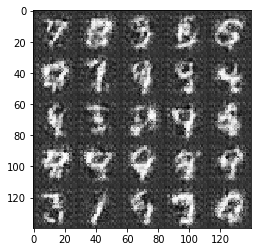

Epoch 1/2	 Batch 410/468	 Discriminator Loss: 0.7413	 Generator Loss: 1.7703
Epoch 1/2	 Batch 420/468	 Discriminator Loss: 0.4944	 Generator Loss: 2.5216
Epoch 1/2	 Batch 430/468	 Discriminator Loss: 0.4852	 Generator Loss: 2.0675
Epoch 1/2	 Batch 440/468	 Discriminator Loss: 0.3573	 Generator Loss: 4.9306
Epoch 1/2	 Batch 450/468	 Discriminator Loss: 0.9012	 Generator Loss: 1.2953
Epoch 1/2	 Batch 460/468	 Discriminator Loss: 0.8685	 Generator Loss: 1.6566
Epoch 1/2	 Batch 468/468	 Discriminator Loss: 0.4968	 Generator Loss: 2.1761


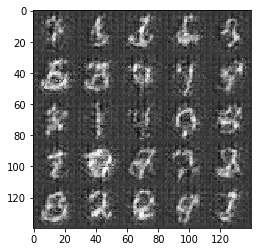

Epoch 2/2	 Batch 10/468	 Discriminator Loss: 0.4254	 Generator Loss: 4.4484
Epoch 2/2	 Batch 20/468	 Discriminator Loss: 0.8331	 Generator Loss: 1.4346
Epoch 2/2	 Batch 30/468	 Discriminator Loss: 0.7556	 Generator Loss: 2.6669
Epoch 2/2	 Batch 40/468	 Discriminator Loss: 1.0831	 Generator Loss: 0.7463
Epoch 2/2	 Batch 50/468	 Discriminator Loss: 0.6167	 Generator Loss: 1.4800
Epoch 2/2	 Batch 60/468	 Discriminator Loss: 0.4283	 Generator Loss: 2.5222
Epoch 2/2	 Batch 70/468	 Discriminator Loss: 0.5581	 Generator Loss: 1.6896
Epoch 2/2	 Batch 80/468	 Discriminator Loss: 0.4036	 Generator Loss: 2.7725
Epoch 2/2	 Batch 90/468	 Discriminator Loss: 0.3710	 Generator Loss: 4.0555
Epoch 2/2	 Batch 100/468	 Discriminator Loss: 0.3428	 Generator Loss: 4.6671
Epoch 2/2	 Batch 110/468	 Discriminator Loss: 0.3781	 Generator Loss: 3.4688
Epoch 2/2	 Batch 120/468	 Discriminator Loss: 0.3627	 Generator Loss: 3.6747
Epoch 2/2	 Batch 130/468	 Discriminator Loss: 7.8201	 Generator Loss: 8.8223
Epoch 2/

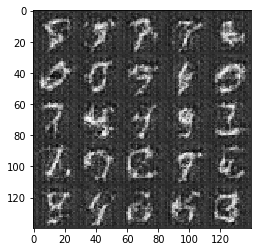

Epoch 2/2	 Batch 210/468	 Discriminator Loss: 0.4011	 Generator Loss: 2.8834
Epoch 2/2	 Batch 220/468	 Discriminator Loss: 0.4054	 Generator Loss: 2.9093
Epoch 2/2	 Batch 230/468	 Discriminator Loss: 0.3774	 Generator Loss: 3.2199
Epoch 2/2	 Batch 240/468	 Discriminator Loss: 0.3393	 Generator Loss: 5.2228
Epoch 2/2	 Batch 250/468	 Discriminator Loss: 5.2784	 Generator Loss: 6.4013
Epoch 2/2	 Batch 260/468	 Discriminator Loss: 1.8843	 Generator Loss: 3.0182
Epoch 2/2	 Batch 270/468	 Discriminator Loss: 1.5152	 Generator Loss: 2.4589
Epoch 2/2	 Batch 280/468	 Discriminator Loss: 1.1149	 Generator Loss: 2.2035
Epoch 2/2	 Batch 290/468	 Discriminator Loss: 1.6255	 Generator Loss: 2.2563
Epoch 2/2	 Batch 300/468	 Discriminator Loss: 0.7716	 Generator Loss: 1.8904
Epoch 2/2	 Batch 310/468	 Discriminator Loss: 0.5279	 Generator Loss: 2.0821
Epoch 2/2	 Batch 320/468	 Discriminator Loss: 0.4860	 Generator Loss: 2.0073
Epoch 2/2	 Batch 330/468	 Discriminator Loss: 0.3993	 Generator Loss: 4.4993

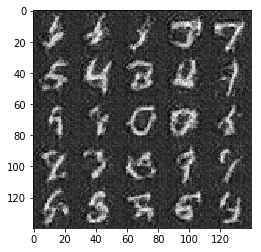

Epoch 2/2	 Batch 410/468	 Discriminator Loss: 2.3197	 Generator Loss: 4.1068
Epoch 2/2	 Batch 420/468	 Discriminator Loss: 1.4011	 Generator Loss: 2.0133
Epoch 2/2	 Batch 430/468	 Discriminator Loss: 0.5043	 Generator Loss: 2.7343
Epoch 2/2	 Batch 440/468	 Discriminator Loss: 0.4015	 Generator Loss: 2.8030
Epoch 2/2	 Batch 450/468	 Discriminator Loss: 0.3638	 Generator Loss: 3.7004
Epoch 2/2	 Batch 460/468	 Discriminator Loss: 0.3617	 Generator Loss: 3.6375
Epoch 2/2	 Batch 468/468	 Discriminator Loss: 0.4368	 Generator Loss: 2.4024


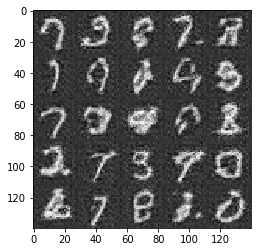

In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10	 Batch 10/791	 Discriminator Loss: 0.5531	 Generator Loss: 8.9755
Epoch 1/10	 Batch 20/791	 Discriminator Loss: 0.5796	 Generator Loss: 11.7926
Epoch 1/10	 Batch 30/791	 Discriminator Loss: 0.4783	 Generator Loss: 4.2096
Epoch 1/10	 Batch 40/791	 Discriminator Loss: 1.4073	 Generator Loss: 0.9185
Epoch 1/10	 Batch 50/791	 Discriminator Loss: 2.2667	 Generator Loss: 5.9736
Epoch 1/10	 Batch 60/791	 Discriminator Loss: 1.0449	 Generator Loss: 4.7453
Epoch 1/10	 Batch 70/791	 Discriminator Loss: 0.7619	 Generator Loss: 1.4926
Epoch 1/10	 Batch 80/791	 Discriminator Loss: 0.5721	 Generator Loss: 2.0715
Epoch 1/10	 Batch 90/791	 Discriminator Loss: 0.7059	 Generator Loss: 1.2933
Epoch 1/10	 Batch 100/791	 Discriminator Loss: 0.5325	 Generator Loss: 1.9536
Epoch 1/10	 Batch 110/791	 Discriminator Loss: 3.9002	 Generator Loss: 0.0384
Epoch 1/10	 Batch 120/791	 Discriminator Loss: 0.5959	 Generator Loss: 1.9527
Epoch 1/10	 Batch 130/791	 Discriminator Loss: 0.4280	 Generator Loss: 2

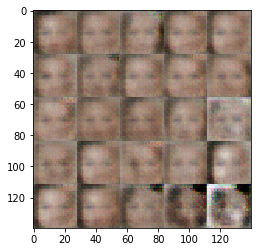

Epoch 1/10	 Batch 210/791	 Discriminator Loss: 0.8186	 Generator Loss: 1.2194
Epoch 1/10	 Batch 220/791	 Discriminator Loss: 0.7434	 Generator Loss: 1.8454
Epoch 1/10	 Batch 230/791	 Discriminator Loss: 1.2486	 Generator Loss: 0.6864
Epoch 1/10	 Batch 240/791	 Discriminator Loss: 0.6250	 Generator Loss: 1.8062
Epoch 1/10	 Batch 250/791	 Discriminator Loss: 1.1493	 Generator Loss: 1.2777
Epoch 1/10	 Batch 260/791	 Discriminator Loss: 0.5322	 Generator Loss: 3.5845
Epoch 1/10	 Batch 270/791	 Discriminator Loss: 0.5304	 Generator Loss: 2.2134
Epoch 1/10	 Batch 280/791	 Discriminator Loss: 0.9997	 Generator Loss: 1.8483
Epoch 1/10	 Batch 290/791	 Discriminator Loss: 1.3135	 Generator Loss: 2.9182
Epoch 1/10	 Batch 300/791	 Discriminator Loss: 0.9540	 Generator Loss: 3.8187
Epoch 1/10	 Batch 310/791	 Discriminator Loss: 0.5457	 Generator Loss: 2.6329
Epoch 1/10	 Batch 320/791	 Discriminator Loss: 0.5587	 Generator Loss: 2.7063
Epoch 1/10	 Batch 330/791	 Discriminator Loss: 0.3930	 Generator

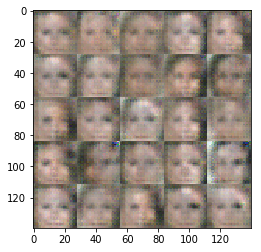

Epoch 1/10	 Batch 410/791	 Discriminator Loss: 0.7712	 Generator Loss: 1.9561
Epoch 1/10	 Batch 420/791	 Discriminator Loss: 0.8668	 Generator Loss: 3.7970
Epoch 1/10	 Batch 430/791	 Discriminator Loss: 0.9589	 Generator Loss: 2.0879
Epoch 1/10	 Batch 440/791	 Discriminator Loss: 1.8349	 Generator Loss: 0.3267
Epoch 1/10	 Batch 450/791	 Discriminator Loss: 0.9444	 Generator Loss: 3.8091
Epoch 1/10	 Batch 460/791	 Discriminator Loss: 0.5560	 Generator Loss: 2.9379
Epoch 1/10	 Batch 470/791	 Discriminator Loss: 0.5906	 Generator Loss: 1.6954
Epoch 1/10	 Batch 480/791	 Discriminator Loss: 0.3515	 Generator Loss: 5.0241
Epoch 1/10	 Batch 490/791	 Discriminator Loss: 0.3476	 Generator Loss: 5.3520
Epoch 1/10	 Batch 500/791	 Discriminator Loss: 0.3613	 Generator Loss: 3.7466
Epoch 1/10	 Batch 510/791	 Discriminator Loss: 0.4061	 Generator Loss: 2.7613
Epoch 1/10	 Batch 520/791	 Discriminator Loss: 0.3348	 Generator Loss: 6.1089
Epoch 1/10	 Batch 530/791	 Discriminator Loss: 0.3440	 Generator

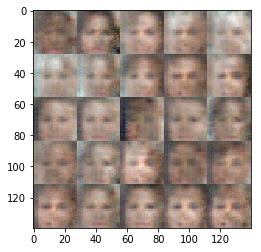

Epoch 1/10	 Batch 610/791	 Discriminator Loss: 1.3156	 Generator Loss: 1.2036
Epoch 1/10	 Batch 620/791	 Discriminator Loss: 1.3056	 Generator Loss: 0.9334
Epoch 1/10	 Batch 630/791	 Discriminator Loss: 1.8114	 Generator Loss: 2.4857
Epoch 1/10	 Batch 640/791	 Discriminator Loss: 0.8635	 Generator Loss: 1.1910
Epoch 1/10	 Batch 650/791	 Discriminator Loss: 1.3165	 Generator Loss: 1.3376
Epoch 1/10	 Batch 660/791	 Discriminator Loss: 1.3214	 Generator Loss: 0.8389
Epoch 1/10	 Batch 670/791	 Discriminator Loss: 1.5104	 Generator Loss: 0.4241
Epoch 1/10	 Batch 680/791	 Discriminator Loss: 0.5161	 Generator Loss: 3.0919
Epoch 1/10	 Batch 690/791	 Discriminator Loss: 1.2821	 Generator Loss: 0.8639
Epoch 1/10	 Batch 700/791	 Discriminator Loss: 1.1972	 Generator Loss: 0.8988
Epoch 1/10	 Batch 710/791	 Discriminator Loss: 1.2724	 Generator Loss: 0.7897
Epoch 1/10	 Batch 720/791	 Discriminator Loss: 0.6871	 Generator Loss: 1.5192
Epoch 1/10	 Batch 730/791	 Discriminator Loss: 0.9296	 Generator

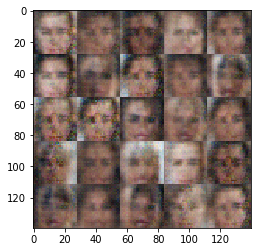

Epoch 2/10	 Batch 10/791	 Discriminator Loss: 1.2470	 Generator Loss: 0.6522
Epoch 2/10	 Batch 20/791	 Discriminator Loss: 1.2611	 Generator Loss: 0.7124
Epoch 2/10	 Batch 30/791	 Discriminator Loss: 1.2641	 Generator Loss: 0.8178
Epoch 2/10	 Batch 40/791	 Discriminator Loss: 1.2520	 Generator Loss: 0.8470
Epoch 2/10	 Batch 50/791	 Discriminator Loss: 1.2529	 Generator Loss: 0.7250
Epoch 2/10	 Batch 60/791	 Discriminator Loss: 1.3036	 Generator Loss: 0.7229
Epoch 2/10	 Batch 70/791	 Discriminator Loss: 1.2509	 Generator Loss: 0.7359
Epoch 2/10	 Batch 80/791	 Discriminator Loss: 1.4966	 Generator Loss: 0.4720
Epoch 2/10	 Batch 90/791	 Discriminator Loss: 1.3200	 Generator Loss: 0.5851
Epoch 2/10	 Batch 100/791	 Discriminator Loss: 1.3879	 Generator Loss: 0.4965
Epoch 2/10	 Batch 110/791	 Discriminator Loss: 0.8264	 Generator Loss: 1.3161
Epoch 2/10	 Batch 120/791	 Discriminator Loss: 1.0994	 Generator Loss: 0.7187
Epoch 2/10	 Batch 130/791	 Discriminator Loss: 0.4691	 Generator Loss: 2.

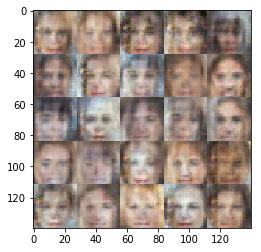

Epoch 2/10	 Batch 210/791	 Discriminator Loss: 1.4950	 Generator Loss: 3.4613
Epoch 2/10	 Batch 220/791	 Discriminator Loss: 1.6451	 Generator Loss: 2.8512
Epoch 2/10	 Batch 230/791	 Discriminator Loss: 2.5424	 Generator Loss: 2.6358
Epoch 2/10	 Batch 240/791	 Discriminator Loss: 0.6727	 Generator Loss: 1.2922
Epoch 2/10	 Batch 250/791	 Discriminator Loss: 1.6575	 Generator Loss: 0.9143
Epoch 2/10	 Batch 260/791	 Discriminator Loss: 0.5884	 Generator Loss: 1.6528
Epoch 2/10	 Batch 270/791	 Discriminator Loss: 1.6933	 Generator Loss: 0.4899
Epoch 2/10	 Batch 280/791	 Discriminator Loss: 0.7969	 Generator Loss: 2.0215
Epoch 2/10	 Batch 290/791	 Discriminator Loss: 0.6335	 Generator Loss: 2.1166
Epoch 2/10	 Batch 300/791	 Discriminator Loss: 2.6585	 Generator Loss: 4.1892
Epoch 2/10	 Batch 310/791	 Discriminator Loss: 1.1819	 Generator Loss: 0.8070
Epoch 2/10	 Batch 320/791	 Discriminator Loss: 1.0505	 Generator Loss: 0.7677
Epoch 2/10	 Batch 330/791	 Discriminator Loss: 0.4352	 Generator

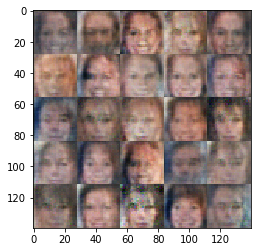

Epoch 2/10	 Batch 410/791	 Discriminator Loss: 1.8352	 Generator Loss: 0.2996
Epoch 2/10	 Batch 420/791	 Discriminator Loss: 1.5541	 Generator Loss: 0.5888
Epoch 2/10	 Batch 430/791	 Discriminator Loss: 1.3021	 Generator Loss: 0.6898
Epoch 2/10	 Batch 440/791	 Discriminator Loss: 1.0870	 Generator Loss: 1.1334
Epoch 2/10	 Batch 450/791	 Discriminator Loss: 0.6569	 Generator Loss: 2.7218
Epoch 2/10	 Batch 460/791	 Discriminator Loss: 0.4661	 Generator Loss: 3.1746
Epoch 2/10	 Batch 470/791	 Discriminator Loss: 1.3660	 Generator Loss: 0.7605
Epoch 2/10	 Batch 480/791	 Discriminator Loss: 1.2256	 Generator Loss: 1.1127
Epoch 2/10	 Batch 490/791	 Discriminator Loss: 1.5321	 Generator Loss: 3.1175
Epoch 2/10	 Batch 500/791	 Discriminator Loss: 0.4171	 Generator Loss: 2.6928
Epoch 2/10	 Batch 510/791	 Discriminator Loss: 0.8936	 Generator Loss: 0.8977
Epoch 2/10	 Batch 520/791	 Discriminator Loss: 1.4427	 Generator Loss: 0.5222
Epoch 2/10	 Batch 530/791	 Discriminator Loss: 0.7196	 Generator

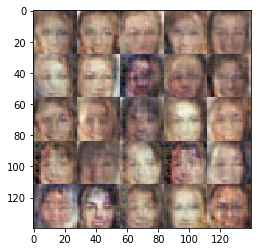

Epoch 2/10	 Batch 610/791	 Discriminator Loss: 0.5228	 Generator Loss: 1.9122
Epoch 2/10	 Batch 620/791	 Discriminator Loss: 2.3057	 Generator Loss: 2.7252
Epoch 2/10	 Batch 630/791	 Discriminator Loss: 0.7632	 Generator Loss: 1.1054
Epoch 2/10	 Batch 640/791	 Discriminator Loss: 1.3457	 Generator Loss: 0.8913
Epoch 2/10	 Batch 650/791	 Discriminator Loss: 1.0913	 Generator Loss: 3.1454
Epoch 2/10	 Batch 660/791	 Discriminator Loss: 0.9427	 Generator Loss: 1.0694
Epoch 2/10	 Batch 670/791	 Discriminator Loss: 0.9738	 Generator Loss: 1.5583
Epoch 2/10	 Batch 680/791	 Discriminator Loss: 0.5542	 Generator Loss: 3.5444
Epoch 2/10	 Batch 690/791	 Discriminator Loss: 0.7735	 Generator Loss: 1.0814
Epoch 2/10	 Batch 700/791	 Discriminator Loss: 0.7880	 Generator Loss: 1.0844
Epoch 2/10	 Batch 710/791	 Discriminator Loss: 1.2926	 Generator Loss: 0.6192
Epoch 2/10	 Batch 720/791	 Discriminator Loss: 0.9999	 Generator Loss: 0.8151
Epoch 2/10	 Batch 730/791	 Discriminator Loss: 1.4667	 Generator

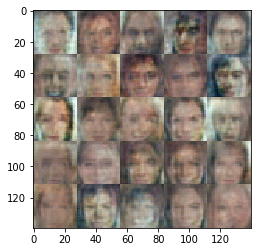

Epoch 3/10	 Batch 10/791	 Discriminator Loss: 1.1825	 Generator Loss: 0.9252
Epoch 3/10	 Batch 20/791	 Discriminator Loss: 1.1867	 Generator Loss: 0.8131
Epoch 3/10	 Batch 30/791	 Discriminator Loss: 1.5966	 Generator Loss: 0.3603
Epoch 3/10	 Batch 40/791	 Discriminator Loss: 1.0988	 Generator Loss: 0.7639
Epoch 3/10	 Batch 50/791	 Discriminator Loss: 0.8749	 Generator Loss: 1.0351
Epoch 3/10	 Batch 60/791	 Discriminator Loss: 0.7572	 Generator Loss: 1.4904
Epoch 3/10	 Batch 70/791	 Discriminator Loss: 1.2489	 Generator Loss: 0.9777
Epoch 3/10	 Batch 80/791	 Discriminator Loss: 1.1444	 Generator Loss: 1.4893
Epoch 3/10	 Batch 90/791	 Discriminator Loss: 1.3158	 Generator Loss: 1.7892
Epoch 3/10	 Batch 100/791	 Discriminator Loss: 0.5385	 Generator Loss: 2.4008
Epoch 3/10	 Batch 110/791	 Discriminator Loss: 1.1637	 Generator Loss: 0.6127
Epoch 3/10	 Batch 120/791	 Discriminator Loss: 0.7097	 Generator Loss: 3.6119
Epoch 3/10	 Batch 130/791	 Discriminator Loss: 0.7413	 Generator Loss: 2.

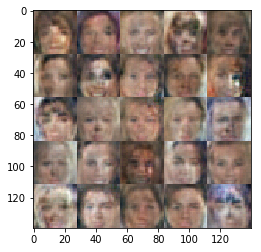

Epoch 3/10	 Batch 210/791	 Discriminator Loss: 0.9364	 Generator Loss: 0.8975
Epoch 3/10	 Batch 220/791	 Discriminator Loss: 1.2388	 Generator Loss: 0.8105
Epoch 3/10	 Batch 230/791	 Discriminator Loss: 0.9728	 Generator Loss: 0.8063
Epoch 3/10	 Batch 240/791	 Discriminator Loss: 0.9939	 Generator Loss: 1.1248
Epoch 3/10	 Batch 250/791	 Discriminator Loss: 0.6647	 Generator Loss: 1.4780
Epoch 3/10	 Batch 260/791	 Discriminator Loss: 1.2451	 Generator Loss: 2.2751
Epoch 3/10	 Batch 270/791	 Discriminator Loss: 2.3076	 Generator Loss: 2.9088
Epoch 3/10	 Batch 280/791	 Discriminator Loss: 1.6222	 Generator Loss: 2.0738
Epoch 3/10	 Batch 290/791	 Discriminator Loss: 1.7796	 Generator Loss: 1.1385
Epoch 3/10	 Batch 300/791	 Discriminator Loss: 1.2248	 Generator Loss: 0.9106
Epoch 3/10	 Batch 310/791	 Discriminator Loss: 1.3223	 Generator Loss: 0.6997
Epoch 3/10	 Batch 320/791	 Discriminator Loss: 0.7524	 Generator Loss: 2.3480
Epoch 3/10	 Batch 330/791	 Discriminator Loss: 1.8223	 Generator

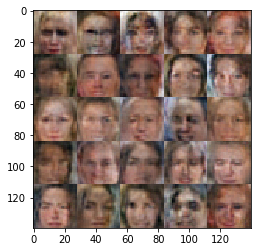

Epoch 3/10	 Batch 410/791	 Discriminator Loss: 1.3227	 Generator Loss: 2.3898
Epoch 3/10	 Batch 420/791	 Discriminator Loss: 1.2730	 Generator Loss: 1.1692
Epoch 3/10	 Batch 430/791	 Discriminator Loss: 1.4582	 Generator Loss: 0.4339
Epoch 3/10	 Batch 440/791	 Discriminator Loss: 1.0753	 Generator Loss: 0.7962
Epoch 3/10	 Batch 450/791	 Discriminator Loss: 1.2886	 Generator Loss: 1.0914
Epoch 3/10	 Batch 460/791	 Discriminator Loss: 1.3183	 Generator Loss: 1.0351
Epoch 3/10	 Batch 470/791	 Discriminator Loss: 1.2363	 Generator Loss: 0.5775
Epoch 3/10	 Batch 480/791	 Discriminator Loss: 1.4753	 Generator Loss: 0.4901
Epoch 3/10	 Batch 490/791	 Discriminator Loss: 1.3998	 Generator Loss: 1.0262
Epoch 3/10	 Batch 500/791	 Discriminator Loss: 1.2333	 Generator Loss: 0.8676
Epoch 3/10	 Batch 510/791	 Discriminator Loss: 1.2608	 Generator Loss: 0.8159
Epoch 3/10	 Batch 520/791	 Discriminator Loss: 1.8143	 Generator Loss: 2.4254
Epoch 3/10	 Batch 530/791	 Discriminator Loss: 1.2195	 Generator

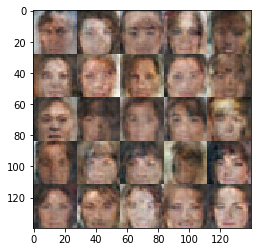

Epoch 3/10	 Batch 610/791	 Discriminator Loss: 1.4756	 Generator Loss: 0.4662
Epoch 3/10	 Batch 620/791	 Discriminator Loss: 1.0277	 Generator Loss: 1.3192
Epoch 3/10	 Batch 630/791	 Discriminator Loss: 0.9130	 Generator Loss: 1.2964
Epoch 3/10	 Batch 640/791	 Discriminator Loss: 0.7540	 Generator Loss: 1.4347
Epoch 3/10	 Batch 650/791	 Discriminator Loss: 1.1979	 Generator Loss: 0.8886
Epoch 3/10	 Batch 660/791	 Discriminator Loss: 0.8812	 Generator Loss: 1.1400
Epoch 3/10	 Batch 670/791	 Discriminator Loss: 1.2708	 Generator Loss: 0.5678
Epoch 3/10	 Batch 680/791	 Discriminator Loss: 1.5000	 Generator Loss: 0.7315
Epoch 3/10	 Batch 690/791	 Discriminator Loss: 1.0592	 Generator Loss: 1.3311
Epoch 3/10	 Batch 700/791	 Discriminator Loss: 0.9520	 Generator Loss: 1.1013
Epoch 3/10	 Batch 710/791	 Discriminator Loss: 0.6091	 Generator Loss: 1.9145
Epoch 3/10	 Batch 720/791	 Discriminator Loss: 1.0903	 Generator Loss: 1.8048
Epoch 3/10	 Batch 730/791	 Discriminator Loss: 0.9988	 Generator

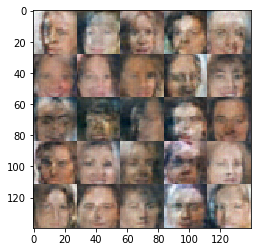

Epoch 4/10	 Batch 10/791	 Discriminator Loss: 1.5546	 Generator Loss: 0.3969
Epoch 4/10	 Batch 20/791	 Discriminator Loss: 1.2780	 Generator Loss: 0.5412
Epoch 4/10	 Batch 30/791	 Discriminator Loss: 1.6171	 Generator Loss: 0.4614
Epoch 4/10	 Batch 40/791	 Discriminator Loss: 1.6151	 Generator Loss: 1.6479
Epoch 4/10	 Batch 50/791	 Discriminator Loss: 0.9784	 Generator Loss: 1.4514
Epoch 4/10	 Batch 60/791	 Discriminator Loss: 1.1105	 Generator Loss: 1.5540
Epoch 4/10	 Batch 70/791	 Discriminator Loss: 1.7976	 Generator Loss: 2.1693
Epoch 4/10	 Batch 80/791	 Discriminator Loss: 1.9535	 Generator Loss: 2.0906
Epoch 4/10	 Batch 90/791	 Discriminator Loss: 1.2680	 Generator Loss: 1.0674
Epoch 4/10	 Batch 100/791	 Discriminator Loss: 1.1038	 Generator Loss: 1.2741
Epoch 4/10	 Batch 110/791	 Discriminator Loss: 1.3860	 Generator Loss: 1.5739
Epoch 4/10	 Batch 120/791	 Discriminator Loss: 1.3344	 Generator Loss: 1.7052
Epoch 4/10	 Batch 130/791	 Discriminator Loss: 1.1732	 Generator Loss: 0.

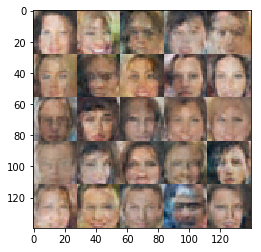

Epoch 4/10	 Batch 210/791	 Discriminator Loss: 1.3888	 Generator Loss: 0.4690
Epoch 4/10	 Batch 220/791	 Discriminator Loss: 1.0743	 Generator Loss: 1.0659
Epoch 4/10	 Batch 230/791	 Discriminator Loss: 1.6032	 Generator Loss: 0.8676
Epoch 4/10	 Batch 240/791	 Discriminator Loss: 1.2580	 Generator Loss: 0.8569
Epoch 4/10	 Batch 250/791	 Discriminator Loss: 1.1992	 Generator Loss: 0.8362
Epoch 4/10	 Batch 260/791	 Discriminator Loss: 1.0268	 Generator Loss: 1.5018
Epoch 4/10	 Batch 270/791	 Discriminator Loss: 1.4209	 Generator Loss: 1.2655
Epoch 4/10	 Batch 280/791	 Discriminator Loss: 1.2050	 Generator Loss: 0.6232
Epoch 4/10	 Batch 290/791	 Discriminator Loss: 0.7529	 Generator Loss: 1.4985
Epoch 4/10	 Batch 300/791	 Discriminator Loss: 2.1984	 Generator Loss: 2.3830
Epoch 4/10	 Batch 310/791	 Discriminator Loss: 1.9390	 Generator Loss: 0.2449
Epoch 4/10	 Batch 320/791	 Discriminator Loss: 1.1233	 Generator Loss: 0.9755
Epoch 4/10	 Batch 330/791	 Discriminator Loss: 1.3710	 Generator

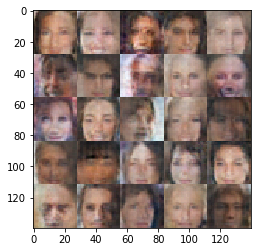

Epoch 4/10	 Batch 410/791	 Discriminator Loss: 1.2442	 Generator Loss: 0.8196
Epoch 4/10	 Batch 420/791	 Discriminator Loss: 1.1273	 Generator Loss: 1.2228
Epoch 4/10	 Batch 430/791	 Discriminator Loss: 1.3495	 Generator Loss: 0.6322
Epoch 4/10	 Batch 440/791	 Discriminator Loss: 1.4814	 Generator Loss: 1.3175
Epoch 4/10	 Batch 450/791	 Discriminator Loss: 1.3763	 Generator Loss: 1.3223
Epoch 4/10	 Batch 460/791	 Discriminator Loss: 0.9857	 Generator Loss: 1.2834
Epoch 4/10	 Batch 470/791	 Discriminator Loss: 1.1137	 Generator Loss: 0.9585
Epoch 4/10	 Batch 480/791	 Discriminator Loss: 1.3172	 Generator Loss: 0.6065
Epoch 4/10	 Batch 490/791	 Discriminator Loss: 0.9718	 Generator Loss: 1.1392
Epoch 4/10	 Batch 500/791	 Discriminator Loss: 1.1528	 Generator Loss: 0.6654
Epoch 4/10	 Batch 510/791	 Discriminator Loss: 1.1135	 Generator Loss: 0.9218
Epoch 4/10	 Batch 520/791	 Discriminator Loss: 1.1383	 Generator Loss: 0.7464
Epoch 4/10	 Batch 530/791	 Discriminator Loss: 1.3740	 Generator

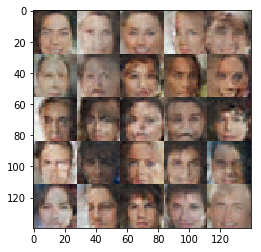

Epoch 4/10	 Batch 610/791	 Discriminator Loss: 0.6941	 Generator Loss: 1.2955
Epoch 4/10	 Batch 620/791	 Discriminator Loss: 1.4932	 Generator Loss: 0.8071
Epoch 4/10	 Batch 630/791	 Discriminator Loss: 1.0218	 Generator Loss: 1.4883
Epoch 4/10	 Batch 640/791	 Discriminator Loss: 1.1965	 Generator Loss: 0.6596
Epoch 4/10	 Batch 650/791	 Discriminator Loss: 1.5790	 Generator Loss: 0.9373
Epoch 4/10	 Batch 660/791	 Discriminator Loss: 1.6186	 Generator Loss: 1.6755
Epoch 4/10	 Batch 670/791	 Discriminator Loss: 1.4657	 Generator Loss: 0.8362
Epoch 4/10	 Batch 680/791	 Discriminator Loss: 1.3540	 Generator Loss: 0.8672
Epoch 4/10	 Batch 690/791	 Discriminator Loss: 1.2689	 Generator Loss: 0.8029
Epoch 4/10	 Batch 700/791	 Discriminator Loss: 1.2962	 Generator Loss: 0.9958
Epoch 4/10	 Batch 710/791	 Discriminator Loss: 1.2682	 Generator Loss: 1.1233
Epoch 4/10	 Batch 720/791	 Discriminator Loss: 1.2268	 Generator Loss: 0.9566
Epoch 4/10	 Batch 730/791	 Discriminator Loss: 1.4088	 Generator

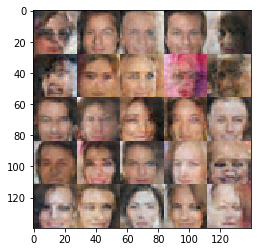

Epoch 5/10	 Batch 10/791	 Discriminator Loss: 1.2641	 Generator Loss: 0.8345
Epoch 5/10	 Batch 20/791	 Discriminator Loss: 1.3468	 Generator Loss: 1.0396
Epoch 5/10	 Batch 30/791	 Discriminator Loss: 1.3669	 Generator Loss: 1.0961
Epoch 5/10	 Batch 40/791	 Discriminator Loss: 1.2987	 Generator Loss: 1.0639
Epoch 5/10	 Batch 50/791	 Discriminator Loss: 1.3452	 Generator Loss: 1.2694
Epoch 5/10	 Batch 60/791	 Discriminator Loss: 1.2294	 Generator Loss: 0.9559
Epoch 5/10	 Batch 70/791	 Discriminator Loss: 1.4864	 Generator Loss: 0.4477
Epoch 5/10	 Batch 80/791	 Discriminator Loss: 1.2042	 Generator Loss: 0.8873
Epoch 5/10	 Batch 90/791	 Discriminator Loss: 2.8096	 Generator Loss: 2.7734
Epoch 5/10	 Batch 100/791	 Discriminator Loss: 1.3847	 Generator Loss: 0.7747
Epoch 5/10	 Batch 110/791	 Discriminator Loss: 1.2809	 Generator Loss: 0.7974
Epoch 5/10	 Batch 120/791	 Discriminator Loss: 0.8261	 Generator Loss: 1.7525
Epoch 5/10	 Batch 130/791	 Discriminator Loss: 1.3095	 Generator Loss: 0.

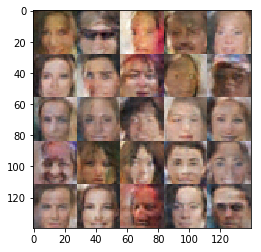

Epoch 5/10	 Batch 210/791	 Discriminator Loss: 1.6752	 Generator Loss: 0.8255
Epoch 5/10	 Batch 220/791	 Discriminator Loss: 1.4650	 Generator Loss: 1.1441
Epoch 5/10	 Batch 230/791	 Discriminator Loss: 1.5006	 Generator Loss: 0.6443
Epoch 5/10	 Batch 240/791	 Discriminator Loss: 1.3446	 Generator Loss: 1.0385
Epoch 5/10	 Batch 250/791	 Discriminator Loss: 1.3759	 Generator Loss: 1.1938
Epoch 5/10	 Batch 260/791	 Discriminator Loss: 1.2721	 Generator Loss: 0.8703
Epoch 5/10	 Batch 270/791	 Discriminator Loss: 1.0084	 Generator Loss: 1.0378
Epoch 5/10	 Batch 280/791	 Discriminator Loss: 2.5325	 Generator Loss: 2.6823
Epoch 5/10	 Batch 290/791	 Discriminator Loss: 1.3257	 Generator Loss: 0.7966
Epoch 5/10	 Batch 300/791	 Discriminator Loss: 1.2647	 Generator Loss: 0.8077
Epoch 5/10	 Batch 310/791	 Discriminator Loss: 1.3694	 Generator Loss: 0.5596
Epoch 5/10	 Batch 320/791	 Discriminator Loss: 1.4698	 Generator Loss: 0.5608
Epoch 5/10	 Batch 330/791	 Discriminator Loss: 1.3620	 Generator

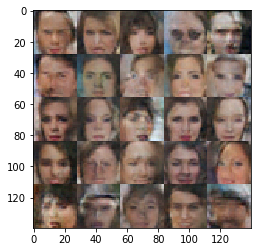

Epoch 5/10	 Batch 410/791	 Discriminator Loss: 0.9435	 Generator Loss: 0.9669
Epoch 5/10	 Batch 420/791	 Discriminator Loss: 1.2636	 Generator Loss: 0.5389
Epoch 5/10	 Batch 430/791	 Discriminator Loss: 1.8313	 Generator Loss: 0.5727
Epoch 5/10	 Batch 440/791	 Discriminator Loss: 1.4520	 Generator Loss: 0.7122
Epoch 5/10	 Batch 450/791	 Discriminator Loss: 1.3422	 Generator Loss: 0.6777
Epoch 5/10	 Batch 460/791	 Discriminator Loss: 1.0353	 Generator Loss: 0.8243
Epoch 5/10	 Batch 470/791	 Discriminator Loss: 1.4733	 Generator Loss: 0.7812
Epoch 5/10	 Batch 480/791	 Discriminator Loss: 1.3248	 Generator Loss: 0.8149
Epoch 5/10	 Batch 490/791	 Discriminator Loss: 1.2233	 Generator Loss: 0.6964
Epoch 5/10	 Batch 500/791	 Discriminator Loss: 1.3865	 Generator Loss: 1.2028
Epoch 5/10	 Batch 510/791	 Discriminator Loss: 0.8414	 Generator Loss: 1.0672
Epoch 5/10	 Batch 520/791	 Discriminator Loss: 2.0321	 Generator Loss: 0.9907
Epoch 5/10	 Batch 530/791	 Discriminator Loss: 1.3261	 Generator

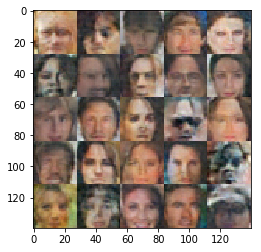

Epoch 5/10	 Batch 610/791	 Discriminator Loss: 1.4081	 Generator Loss: 1.5028
Epoch 5/10	 Batch 620/791	 Discriminator Loss: 1.2784	 Generator Loss: 0.9607
Epoch 5/10	 Batch 630/791	 Discriminator Loss: 0.5271	 Generator Loss: 2.3092
Epoch 5/10	 Batch 640/791	 Discriminator Loss: 1.4212	 Generator Loss: 0.8803
Epoch 5/10	 Batch 650/791	 Discriminator Loss: 0.7694	 Generator Loss: 1.6480
Epoch 5/10	 Batch 660/791	 Discriminator Loss: 1.0484	 Generator Loss: 1.2963
Epoch 5/10	 Batch 670/791	 Discriminator Loss: 0.9272	 Generator Loss: 0.8461
Epoch 5/10	 Batch 680/791	 Discriminator Loss: 0.7784	 Generator Loss: 1.1176
Epoch 5/10	 Batch 690/791	 Discriminator Loss: 1.5371	 Generator Loss: 0.7838
Epoch 5/10	 Batch 700/791	 Discriminator Loss: 1.3836	 Generator Loss: 0.7005
Epoch 5/10	 Batch 710/791	 Discriminator Loss: 1.2852	 Generator Loss: 0.8046
Epoch 5/10	 Batch 720/791	 Discriminator Loss: 1.2498	 Generator Loss: 0.9438
Epoch 5/10	 Batch 730/791	 Discriminator Loss: 1.2869	 Generator

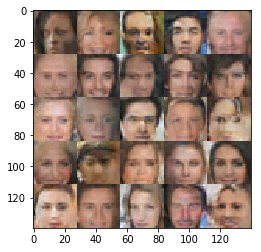

Epoch 6/10	 Batch 10/791	 Discriminator Loss: 1.2805	 Generator Loss: 0.8380
Epoch 6/10	 Batch 20/791	 Discriminator Loss: 1.3504	 Generator Loss: 0.9366
Epoch 6/10	 Batch 30/791	 Discriminator Loss: 1.6308	 Generator Loss: 1.2775
Epoch 6/10	 Batch 40/791	 Discriminator Loss: 1.2948	 Generator Loss: 0.8766
Epoch 6/10	 Batch 50/791	 Discriminator Loss: 1.3485	 Generator Loss: 0.5834
Epoch 6/10	 Batch 60/791	 Discriminator Loss: 1.4124	 Generator Loss: 0.5735
Epoch 6/10	 Batch 70/791	 Discriminator Loss: 1.4112	 Generator Loss: 1.0189
Epoch 6/10	 Batch 80/791	 Discriminator Loss: 1.4258	 Generator Loss: 1.1546
Epoch 6/10	 Batch 90/791	 Discriminator Loss: 1.3189	 Generator Loss: 0.7590
Epoch 6/10	 Batch 100/791	 Discriminator Loss: 1.5971	 Generator Loss: 0.6634
Epoch 6/10	 Batch 110/791	 Discriminator Loss: 1.3826	 Generator Loss: 0.7479
Epoch 6/10	 Batch 120/791	 Discriminator Loss: 1.1110	 Generator Loss: 0.8125
Epoch 6/10	 Batch 130/791	 Discriminator Loss: 1.4025	 Generator Loss: 0.

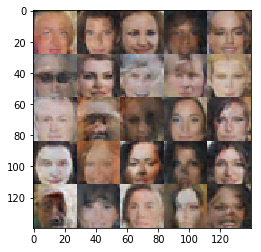

Epoch 6/10	 Batch 210/791	 Discriminator Loss: 2.2870	 Generator Loss: 0.1779
Epoch 6/10	 Batch 220/791	 Discriminator Loss: 1.4179	 Generator Loss: 0.8166
Epoch 6/10	 Batch 230/791	 Discriminator Loss: 1.3843	 Generator Loss: 0.7738
Epoch 6/10	 Batch 240/791	 Discriminator Loss: 1.2938	 Generator Loss: 0.7332
Epoch 6/10	 Batch 250/791	 Discriminator Loss: 1.2945	 Generator Loss: 0.7167
Epoch 6/10	 Batch 260/791	 Discriminator Loss: 1.3294	 Generator Loss: 0.9738
Epoch 6/10	 Batch 270/791	 Discriminator Loss: 1.3420	 Generator Loss: 0.9322
Epoch 6/10	 Batch 280/791	 Discriminator Loss: 1.2845	 Generator Loss: 0.8748
Epoch 6/10	 Batch 290/791	 Discriminator Loss: 1.3341	 Generator Loss: 0.6805
Epoch 6/10	 Batch 300/791	 Discriminator Loss: 1.4465	 Generator Loss: 0.5053
Epoch 6/10	 Batch 310/791	 Discriminator Loss: 1.3242	 Generator Loss: 0.6829
Epoch 6/10	 Batch 320/791	 Discriminator Loss: 1.5189	 Generator Loss: 0.4555
Epoch 6/10	 Batch 330/791	 Discriminator Loss: 1.2978	 Generator

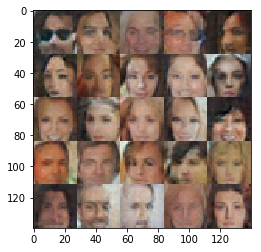

Epoch 6/10	 Batch 410/791	 Discriminator Loss: 0.9915	 Generator Loss: 1.4359
Epoch 6/10	 Batch 420/791	 Discriminator Loss: 1.6723	 Generator Loss: 1.2320
Epoch 6/10	 Batch 430/791	 Discriminator Loss: 1.4114	 Generator Loss: 0.7594
Epoch 6/10	 Batch 440/791	 Discriminator Loss: 1.2983	 Generator Loss: 0.8462
Epoch 6/10	 Batch 450/791	 Discriminator Loss: 1.0030	 Generator Loss: 1.0012
Epoch 6/10	 Batch 460/791	 Discriminator Loss: 1.2708	 Generator Loss: 1.2631
Epoch 6/10	 Batch 470/791	 Discriminator Loss: 1.7659	 Generator Loss: 1.7775
Epoch 6/10	 Batch 480/791	 Discriminator Loss: 0.7603	 Generator Loss: 1.1223
Epoch 6/10	 Batch 490/791	 Discriminator Loss: 1.4380	 Generator Loss: 1.1202
Epoch 6/10	 Batch 500/791	 Discriminator Loss: 1.4000	 Generator Loss: 0.8039
Epoch 6/10	 Batch 510/791	 Discriminator Loss: 1.2987	 Generator Loss: 0.7969
Epoch 6/10	 Batch 520/791	 Discriminator Loss: 1.4597	 Generator Loss: 1.1080
Epoch 6/10	 Batch 530/791	 Discriminator Loss: 1.1900	 Generator

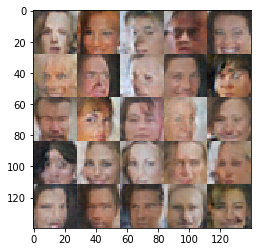

Epoch 6/10	 Batch 610/791	 Discriminator Loss: 1.5235	 Generator Loss: 0.4370
Epoch 6/10	 Batch 620/791	 Discriminator Loss: 1.5172	 Generator Loss: 0.8401
Epoch 6/10	 Batch 630/791	 Discriminator Loss: 1.3126	 Generator Loss: 0.8365
Epoch 6/10	 Batch 640/791	 Discriminator Loss: 1.2038	 Generator Loss: 0.8471
Epoch 6/10	 Batch 650/791	 Discriminator Loss: 0.6832	 Generator Loss: 1.5471
Epoch 6/10	 Batch 660/791	 Discriminator Loss: 0.9371	 Generator Loss: 1.3819
Epoch 6/10	 Batch 670/791	 Discriminator Loss: 1.3035	 Generator Loss: 0.9710
Epoch 6/10	 Batch 680/791	 Discriminator Loss: 1.8338	 Generator Loss: 1.8786
Epoch 6/10	 Batch 690/791	 Discriminator Loss: 1.3231	 Generator Loss: 0.6669
Epoch 6/10	 Batch 700/791	 Discriminator Loss: 0.7691	 Generator Loss: 1.5271
Epoch 6/10	 Batch 710/791	 Discriminator Loss: 1.4122	 Generator Loss: 0.4493
Epoch 6/10	 Batch 720/791	 Discriminator Loss: 0.9349	 Generator Loss: 0.9349
Epoch 6/10	 Batch 730/791	 Discriminator Loss: 1.3000	 Generator

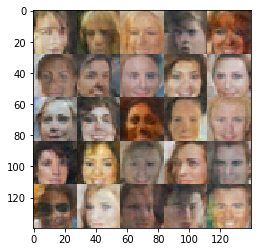

Epoch 7/10	 Batch 10/791	 Discriminator Loss: 1.1360	 Generator Loss: 0.8321
Epoch 7/10	 Batch 20/791	 Discriminator Loss: 1.2908	 Generator Loss: 0.6239
Epoch 7/10	 Batch 30/791	 Discriminator Loss: 0.9105	 Generator Loss: 1.3969
Epoch 7/10	 Batch 40/791	 Discriminator Loss: 1.4230	 Generator Loss: 0.7687
Epoch 7/10	 Batch 50/791	 Discriminator Loss: 1.2926	 Generator Loss: 0.7906
Epoch 7/10	 Batch 60/791	 Discriminator Loss: 1.3225	 Generator Loss: 0.4962
Epoch 7/10	 Batch 70/791	 Discriminator Loss: 1.3667	 Generator Loss: 0.8265
Epoch 7/10	 Batch 80/791	 Discriminator Loss: 1.3368	 Generator Loss: 0.7911
Epoch 7/10	 Batch 90/791	 Discriminator Loss: 0.7532	 Generator Loss: 1.6914
Epoch 7/10	 Batch 100/791	 Discriminator Loss: 1.2822	 Generator Loss: 0.5144
Epoch 7/10	 Batch 110/791	 Discriminator Loss: 1.3599	 Generator Loss: 0.6045
Epoch 7/10	 Batch 120/791	 Discriminator Loss: 1.4496	 Generator Loss: 1.2331
Epoch 7/10	 Batch 130/791	 Discriminator Loss: 1.3076	 Generator Loss: 0.

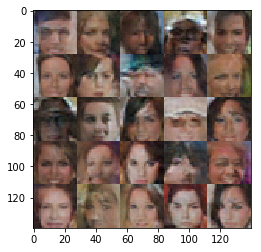

Epoch 7/10	 Batch 210/791	 Discriminator Loss: 1.0313	 Generator Loss: 0.8803
Epoch 7/10	 Batch 220/791	 Discriminator Loss: 1.3884	 Generator Loss: 0.6805
Epoch 7/10	 Batch 230/791	 Discriminator Loss: 1.6688	 Generator Loss: 1.3459
Epoch 7/10	 Batch 240/791	 Discriminator Loss: 0.9375	 Generator Loss: 1.0220
Epoch 7/10	 Batch 250/791	 Discriminator Loss: 1.3904	 Generator Loss: 0.5850
Epoch 7/10	 Batch 260/791	 Discriminator Loss: 1.6677	 Generator Loss: 2.3257
Epoch 7/10	 Batch 270/791	 Discriminator Loss: 1.3089	 Generator Loss: 0.6411
Epoch 7/10	 Batch 280/791	 Discriminator Loss: 1.5463	 Generator Loss: 0.8789
Epoch 7/10	 Batch 290/791	 Discriminator Loss: 1.2314	 Generator Loss: 0.9295
Epoch 7/10	 Batch 300/791	 Discriminator Loss: 1.1879	 Generator Loss: 1.0158
Epoch 7/10	 Batch 310/791	 Discriminator Loss: 1.2169	 Generator Loss: 1.2314
Epoch 7/10	 Batch 320/791	 Discriminator Loss: 1.1882	 Generator Loss: 1.0446
Epoch 7/10	 Batch 330/791	 Discriminator Loss: 1.2499	 Generator

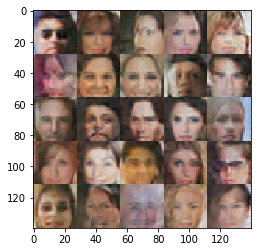

Epoch 7/10	 Batch 410/791	 Discriminator Loss: 0.9603	 Generator Loss: 1.3777
Epoch 7/10	 Batch 420/791	 Discriminator Loss: 1.5114	 Generator Loss: 0.4724
Epoch 7/10	 Batch 430/791	 Discriminator Loss: 1.3508	 Generator Loss: 0.7816
Epoch 7/10	 Batch 440/791	 Discriminator Loss: 1.3987	 Generator Loss: 0.6703
Epoch 7/10	 Batch 450/791	 Discriminator Loss: 1.3610	 Generator Loss: 0.6918
Epoch 7/10	 Batch 460/791	 Discriminator Loss: 1.2853	 Generator Loss: 0.7002
Epoch 7/10	 Batch 470/791	 Discriminator Loss: 1.3069	 Generator Loss: 0.7203
Epoch 7/10	 Batch 480/791	 Discriminator Loss: 1.4167	 Generator Loss: 0.5508
Epoch 7/10	 Batch 490/791	 Discriminator Loss: 0.7264	 Generator Loss: 1.6379
Epoch 7/10	 Batch 500/791	 Discriminator Loss: 1.5761	 Generator Loss: 0.7901
Epoch 7/10	 Batch 510/791	 Discriminator Loss: 0.9884	 Generator Loss: 0.8747
Epoch 7/10	 Batch 520/791	 Discriminator Loss: 1.1345	 Generator Loss: 1.0776
Epoch 7/10	 Batch 530/791	 Discriminator Loss: 1.0267	 Generator

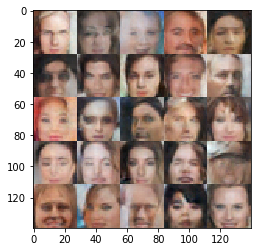

Epoch 7/10	 Batch 610/791	 Discriminator Loss: 1.3749	 Generator Loss: 0.7991
Epoch 7/10	 Batch 620/791	 Discriminator Loss: 1.3865	 Generator Loss: 0.6759
Epoch 7/10	 Batch 630/791	 Discriminator Loss: 1.2893	 Generator Loss: 0.8924
Epoch 7/10	 Batch 640/791	 Discriminator Loss: 1.4388	 Generator Loss: 0.9675
Epoch 7/10	 Batch 650/791	 Discriminator Loss: 1.4544	 Generator Loss: 0.8674
Epoch 7/10	 Batch 660/791	 Discriminator Loss: 1.4819	 Generator Loss: 0.4987
Epoch 7/10	 Batch 670/791	 Discriminator Loss: 0.7881	 Generator Loss: 1.2456
Epoch 7/10	 Batch 680/791	 Discriminator Loss: 1.4295	 Generator Loss: 0.5873
Epoch 7/10	 Batch 690/791	 Discriminator Loss: 1.3509	 Generator Loss: 0.7783
Epoch 7/10	 Batch 700/791	 Discriminator Loss: 1.3632	 Generator Loss: 0.6477
Epoch 7/10	 Batch 710/791	 Discriminator Loss: 1.4603	 Generator Loss: 0.4868
Epoch 7/10	 Batch 720/791	 Discriminator Loss: 1.4778	 Generator Loss: 0.4916
Epoch 7/10	 Batch 730/791	 Discriminator Loss: 1.3621	 Generator

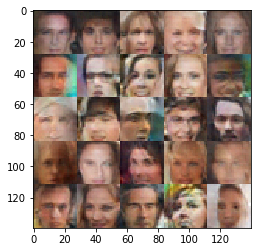

Epoch 8/10	 Batch 10/791	 Discriminator Loss: 2.0610	 Generator Loss: 1.9382
Epoch 8/10	 Batch 20/791	 Discriminator Loss: 1.3832	 Generator Loss: 0.7800
Epoch 8/10	 Batch 30/791	 Discriminator Loss: 1.3910	 Generator Loss: 0.6842
Epoch 8/10	 Batch 40/791	 Discriminator Loss: 1.3144	 Generator Loss: 0.7759
Epoch 8/10	 Batch 50/791	 Discriminator Loss: 1.3475	 Generator Loss: 0.7033
Epoch 8/10	 Batch 60/791	 Discriminator Loss: 1.3103	 Generator Loss: 0.8879
Epoch 8/10	 Batch 70/791	 Discriminator Loss: 1.1708	 Generator Loss: 1.0365
Epoch 8/10	 Batch 80/791	 Discriminator Loss: 2.1481	 Generator Loss: 1.8056
Epoch 8/10	 Batch 90/791	 Discriminator Loss: 1.3924	 Generator Loss: 0.5517
Epoch 8/10	 Batch 100/791	 Discriminator Loss: 1.8932	 Generator Loss: 0.2587
Epoch 8/10	 Batch 110/791	 Discriminator Loss: 1.5296	 Generator Loss: 0.7688
Epoch 8/10	 Batch 120/791	 Discriminator Loss: 1.3803	 Generator Loss: 0.8145
Epoch 8/10	 Batch 130/791	 Discriminator Loss: 1.3540	 Generator Loss: 0.

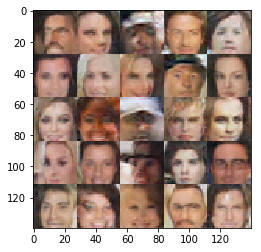

Epoch 8/10	 Batch 210/791	 Discriminator Loss: 1.3749	 Generator Loss: 0.9157
Epoch 8/10	 Batch 220/791	 Discriminator Loss: 1.3112	 Generator Loss: 0.6898
Epoch 8/10	 Batch 230/791	 Discriminator Loss: 1.3474	 Generator Loss: 1.2639
Epoch 8/10	 Batch 240/791	 Discriminator Loss: 1.3222	 Generator Loss: 0.9015
Epoch 8/10	 Batch 250/791	 Discriminator Loss: 1.4423	 Generator Loss: 1.6818
Epoch 8/10	 Batch 260/791	 Discriminator Loss: 1.2290	 Generator Loss: 1.5720
Epoch 8/10	 Batch 270/791	 Discriminator Loss: 0.8659	 Generator Loss: 0.9439
Epoch 8/10	 Batch 280/791	 Discriminator Loss: 1.4532	 Generator Loss: 0.9804
Epoch 8/10	 Batch 290/791	 Discriminator Loss: 1.3117	 Generator Loss: 0.7526
Epoch 8/10	 Batch 300/791	 Discriminator Loss: 1.2713	 Generator Loss: 0.7238
Epoch 8/10	 Batch 310/791	 Discriminator Loss: 1.3154	 Generator Loss: 0.8111
Epoch 8/10	 Batch 320/791	 Discriminator Loss: 1.3788	 Generator Loss: 0.6232
Epoch 8/10	 Batch 330/791	 Discriminator Loss: 1.3955	 Generator

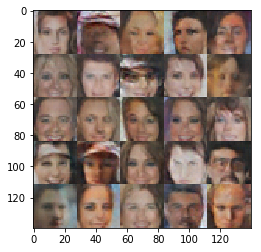

Epoch 8/10	 Batch 410/791	 Discriminator Loss: 1.4893	 Generator Loss: 1.4178
Epoch 8/10	 Batch 420/791	 Discriminator Loss: 1.2388	 Generator Loss: 0.9077
Epoch 8/10	 Batch 430/791	 Discriminator Loss: 1.5783	 Generator Loss: 1.3328
Epoch 8/10	 Batch 440/791	 Discriminator Loss: 1.6316	 Generator Loss: 0.7932
Epoch 8/10	 Batch 450/791	 Discriminator Loss: 1.4410	 Generator Loss: 0.7300
Epoch 8/10	 Batch 460/791	 Discriminator Loss: 1.3218	 Generator Loss: 0.7724
Epoch 8/10	 Batch 470/791	 Discriminator Loss: 1.3349	 Generator Loss: 0.6806
Epoch 8/10	 Batch 480/791	 Discriminator Loss: 1.3130	 Generator Loss: 0.6537
Epoch 8/10	 Batch 490/791	 Discriminator Loss: 1.4390	 Generator Loss: 0.9178
Epoch 8/10	 Batch 500/791	 Discriminator Loss: 1.3823	 Generator Loss: 0.6866
Epoch 8/10	 Batch 510/791	 Discriminator Loss: 1.3505	 Generator Loss: 0.6882
Epoch 8/10	 Batch 520/791	 Discriminator Loss: 1.0830	 Generator Loss: 0.7884
Epoch 8/10	 Batch 530/791	 Discriminator Loss: 1.3656	 Generator

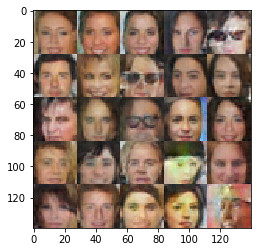

Epoch 8/10	 Batch 610/791	 Discriminator Loss: 1.1907	 Generator Loss: 1.8443
Epoch 8/10	 Batch 620/791	 Discriminator Loss: 1.7201	 Generator Loss: 1.5803
Epoch 8/10	 Batch 630/791	 Discriminator Loss: 0.7115	 Generator Loss: 1.3593
Epoch 8/10	 Batch 640/791	 Discriminator Loss: 1.3259	 Generator Loss: 1.1259
Epoch 8/10	 Batch 650/791	 Discriminator Loss: 1.6525	 Generator Loss: 1.5008
Epoch 8/10	 Batch 660/791	 Discriminator Loss: 0.5602	 Generator Loss: 2.2312
Epoch 8/10	 Batch 670/791	 Discriminator Loss: 1.4065	 Generator Loss: 0.6174
Epoch 8/10	 Batch 680/791	 Discriminator Loss: 1.2379	 Generator Loss: 0.6464
Epoch 8/10	 Batch 690/791	 Discriminator Loss: 1.1843	 Generator Loss: 0.9013
Epoch 8/10	 Batch 700/791	 Discriminator Loss: 0.6974	 Generator Loss: 1.2456
Epoch 8/10	 Batch 710/791	 Discriminator Loss: 1.2448	 Generator Loss: 0.8131
Epoch 8/10	 Batch 720/791	 Discriminator Loss: 1.7051	 Generator Loss: 1.3482
Epoch 8/10	 Batch 730/791	 Discriminator Loss: 1.3864	 Generator

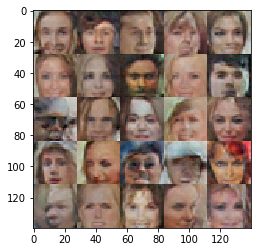

Epoch 9/10	 Batch 10/791	 Discriminator Loss: 1.0468	 Generator Loss: 1.4261
Epoch 9/10	 Batch 20/791	 Discriminator Loss: 1.8234	 Generator Loss: 1.2512
Epoch 9/10	 Batch 30/791	 Discriminator Loss: 1.4238	 Generator Loss: 0.5561
Epoch 9/10	 Batch 40/791	 Discriminator Loss: 1.4223	 Generator Loss: 0.6245
Epoch 9/10	 Batch 50/791	 Discriminator Loss: 1.8141	 Generator Loss: 1.6163
Epoch 9/10	 Batch 60/791	 Discriminator Loss: 0.7561	 Generator Loss: 1.1341
Epoch 9/10	 Batch 70/791	 Discriminator Loss: 1.2778	 Generator Loss: 0.9283
Epoch 9/10	 Batch 80/791	 Discriminator Loss: 1.2622	 Generator Loss: 0.8096
Epoch 9/10	 Batch 90/791	 Discriminator Loss: 1.3550	 Generator Loss: 0.7511
Epoch 9/10	 Batch 100/791	 Discriminator Loss: 1.2498	 Generator Loss: 0.9332
Epoch 9/10	 Batch 110/791	 Discriminator Loss: 1.3561	 Generator Loss: 1.2514
Epoch 9/10	 Batch 120/791	 Discriminator Loss: 1.7401	 Generator Loss: 0.8489
Epoch 9/10	 Batch 130/791	 Discriminator Loss: 1.3641	 Generator Loss: 0.

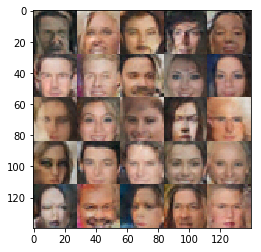

Epoch 9/10	 Batch 210/791	 Discriminator Loss: 1.0087	 Generator Loss: 1.0673
Epoch 9/10	 Batch 220/791	 Discriminator Loss: 1.4926	 Generator Loss: 0.6813
Epoch 9/10	 Batch 230/791	 Discriminator Loss: 1.3548	 Generator Loss: 0.9258
Epoch 9/10	 Batch 240/791	 Discriminator Loss: 0.5630	 Generator Loss: 1.6959
Epoch 9/10	 Batch 250/791	 Discriminator Loss: 1.9451	 Generator Loss: 0.3902
Epoch 9/10	 Batch 260/791	 Discriminator Loss: 1.7480	 Generator Loss: 1.5983
Epoch 9/10	 Batch 270/791	 Discriminator Loss: 1.3444	 Generator Loss: 0.7383
Epoch 9/10	 Batch 280/791	 Discriminator Loss: 1.3634	 Generator Loss: 0.6121
Epoch 9/10	 Batch 290/791	 Discriminator Loss: 1.3534	 Generator Loss: 0.6508
Epoch 9/10	 Batch 300/791	 Discriminator Loss: 1.2114	 Generator Loss: 0.7537
Epoch 9/10	 Batch 310/791	 Discriminator Loss: 1.3982	 Generator Loss: 0.5348
Epoch 9/10	 Batch 320/791	 Discriminator Loss: 1.1190	 Generator Loss: 0.9438
Epoch 9/10	 Batch 330/791	 Discriminator Loss: 2.0733	 Generator

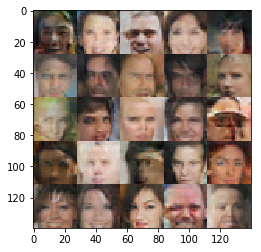

Epoch 9/10	 Batch 410/791	 Discriminator Loss: 1.2303	 Generator Loss: 1.2385
Epoch 9/10	 Batch 420/791	 Discriminator Loss: 0.8331	 Generator Loss: 1.0862
Epoch 9/10	 Batch 430/791	 Discriminator Loss: 2.1594	 Generator Loss: 2.0463
Epoch 9/10	 Batch 440/791	 Discriminator Loss: 1.3850	 Generator Loss: 0.6674
Epoch 9/10	 Batch 450/791	 Discriminator Loss: 1.2896	 Generator Loss: 0.7531
Epoch 9/10	 Batch 460/791	 Discriminator Loss: 1.2797	 Generator Loss: 1.0844
Epoch 9/10	 Batch 470/791	 Discriminator Loss: 0.6794	 Generator Loss: 1.4224
Epoch 9/10	 Batch 480/791	 Discriminator Loss: 1.3225	 Generator Loss: 0.7989
Epoch 9/10	 Batch 490/791	 Discriminator Loss: 1.3724	 Generator Loss: 0.5218
Epoch 9/10	 Batch 500/791	 Discriminator Loss: 2.9689	 Generator Loss: 0.0893
Epoch 9/10	 Batch 510/791	 Discriminator Loss: 1.4358	 Generator Loss: 0.8200
Epoch 9/10	 Batch 520/791	 Discriminator Loss: 1.3795	 Generator Loss: 0.7628
Epoch 9/10	 Batch 530/791	 Discriminator Loss: 1.2912	 Generator

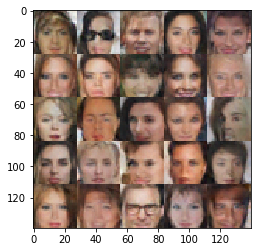

Epoch 9/10	 Batch 610/791	 Discriminator Loss: 1.3864	 Generator Loss: 0.9451
Epoch 9/10	 Batch 620/791	 Discriminator Loss: 1.3018	 Generator Loss: 0.8518
Epoch 9/10	 Batch 630/791	 Discriminator Loss: 1.4475	 Generator Loss: 2.0485
Epoch 9/10	 Batch 640/791	 Discriminator Loss: 1.4028	 Generator Loss: 0.4907
Epoch 9/10	 Batch 650/791	 Discriminator Loss: 1.4618	 Generator Loss: 1.3858
Epoch 9/10	 Batch 660/791	 Discriminator Loss: 1.4358	 Generator Loss: 0.6152
Epoch 9/10	 Batch 670/791	 Discriminator Loss: 1.3036	 Generator Loss: 0.7212
Epoch 9/10	 Batch 680/791	 Discriminator Loss: 1.3512	 Generator Loss: 0.7709
Epoch 9/10	 Batch 690/791	 Discriminator Loss: 1.3940	 Generator Loss: 0.6779
Epoch 9/10	 Batch 700/791	 Discriminator Loss: 1.3796	 Generator Loss: 0.6728
Epoch 9/10	 Batch 710/791	 Discriminator Loss: 1.5408	 Generator Loss: 0.4460
Epoch 9/10	 Batch 720/791	 Discriminator Loss: 1.2390	 Generator Loss: 0.8032
Epoch 9/10	 Batch 730/791	 Discriminator Loss: 1.3867	 Generator

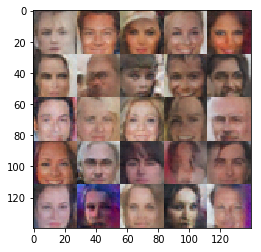

Epoch 10/10	 Batch 10/791	 Discriminator Loss: 1.3451	 Generator Loss: 0.6225
Epoch 10/10	 Batch 20/791	 Discriminator Loss: 1.1938	 Generator Loss: 1.1685
Epoch 10/10	 Batch 30/791	 Discriminator Loss: 1.6304	 Generator Loss: 0.4123
Epoch 10/10	 Batch 40/791	 Discriminator Loss: 1.3527	 Generator Loss: 0.6790
Epoch 10/10	 Batch 50/791	 Discriminator Loss: 1.1592	 Generator Loss: 1.9944
Epoch 10/10	 Batch 60/791	 Discriminator Loss: 1.3949	 Generator Loss: 1.1216
Epoch 10/10	 Batch 70/791	 Discriminator Loss: 1.3618	 Generator Loss: 0.7971
Epoch 10/10	 Batch 80/791	 Discriminator Loss: 1.3389	 Generator Loss: 0.6085
Epoch 10/10	 Batch 90/791	 Discriminator Loss: 1.5045	 Generator Loss: 0.4013
Epoch 10/10	 Batch 100/791	 Discriminator Loss: 1.0818	 Generator Loss: 0.8824
Epoch 10/10	 Batch 110/791	 Discriminator Loss: 0.8684	 Generator Loss: 1.2248
Epoch 10/10	 Batch 120/791	 Discriminator Loss: 1.6188	 Generator Loss: 1.0385
Epoch 10/10	 Batch 130/791	 Discriminator Loss: 1.4425	 Gener

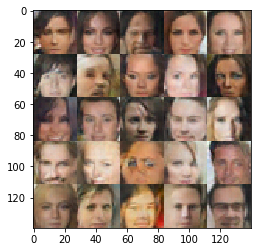

Epoch 10/10	 Batch 210/791	 Discriminator Loss: 1.3652	 Generator Loss: 0.6749
Epoch 10/10	 Batch 220/791	 Discriminator Loss: 1.2952	 Generator Loss: 0.9059
Epoch 10/10	 Batch 230/791	 Discriminator Loss: 1.3585	 Generator Loss: 0.6367
Epoch 10/10	 Batch 240/791	 Discriminator Loss: 1.3949	 Generator Loss: 1.0712
Epoch 10/10	 Batch 250/791	 Discriminator Loss: 1.3657	 Generator Loss: 0.8957
Epoch 10/10	 Batch 260/791	 Discriminator Loss: 1.3794	 Generator Loss: 0.8528
Epoch 10/10	 Batch 270/791	 Discriminator Loss: 1.3567	 Generator Loss: 0.7217
Epoch 10/10	 Batch 280/791	 Discriminator Loss: 1.3318	 Generator Loss: 0.8031
Epoch 10/10	 Batch 290/791	 Discriminator Loss: 1.3059	 Generator Loss: 0.7044
Epoch 10/10	 Batch 300/791	 Discriminator Loss: 1.4853	 Generator Loss: 0.5015
Epoch 10/10	 Batch 310/791	 Discriminator Loss: 1.3253	 Generator Loss: 0.7351
Epoch 10/10	 Batch 320/791	 Discriminator Loss: 1.3915	 Generator Loss: 0.5741
Epoch 10/10	 Batch 330/791	 Discriminator Loss: 1.28

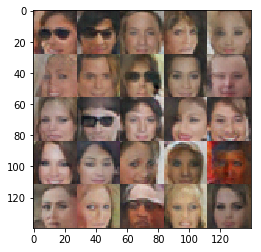

Epoch 10/10	 Batch 410/791	 Discriminator Loss: 1.3609	 Generator Loss: 0.8954
Epoch 10/10	 Batch 420/791	 Discriminator Loss: 1.5502	 Generator Loss: 1.3168
Epoch 10/10	 Batch 430/791	 Discriminator Loss: 1.3970	 Generator Loss: 0.6120
Epoch 10/10	 Batch 440/791	 Discriminator Loss: 1.3838	 Generator Loss: 0.8408
Epoch 10/10	 Batch 450/791	 Discriminator Loss: 1.3832	 Generator Loss: 0.6911
Epoch 10/10	 Batch 460/791	 Discriminator Loss: 1.3106	 Generator Loss: 0.7723
Epoch 10/10	 Batch 470/791	 Discriminator Loss: 1.3289	 Generator Loss: 0.8273
Epoch 10/10	 Batch 480/791	 Discriminator Loss: 1.3505	 Generator Loss: 0.9634
Epoch 10/10	 Batch 490/791	 Discriminator Loss: 1.3026	 Generator Loss: 1.0528
Epoch 10/10	 Batch 500/791	 Discriminator Loss: 1.3759	 Generator Loss: 0.6430
Epoch 10/10	 Batch 510/791	 Discriminator Loss: 1.4191	 Generator Loss: 0.5317
Epoch 10/10	 Batch 520/791	 Discriminator Loss: 1.5078	 Generator Loss: 0.5067
Epoch 10/10	 Batch 530/791	 Discriminator Loss: 1.44

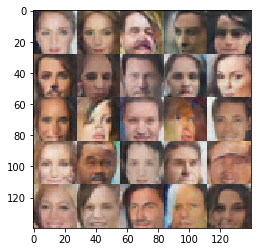

Epoch 10/10	 Batch 610/791	 Discriminator Loss: 1.3523	 Generator Loss: 0.6447
Epoch 10/10	 Batch 620/791	 Discriminator Loss: 1.4345	 Generator Loss: 0.6587
Epoch 10/10	 Batch 630/791	 Discriminator Loss: 1.3592	 Generator Loss: 0.7399
Epoch 10/10	 Batch 640/791	 Discriminator Loss: 1.4749	 Generator Loss: 0.5048
Epoch 10/10	 Batch 650/791	 Discriminator Loss: 1.3258	 Generator Loss: 0.7177
Epoch 10/10	 Batch 660/791	 Discriminator Loss: 1.5814	 Generator Loss: 0.4135
Epoch 10/10	 Batch 670/791	 Discriminator Loss: 1.4334	 Generator Loss: 0.5033


In [ ]:
batch_size = 256
z_dim = 128
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.